# **Melanoma Skin Cancer Detection Model**

**Phase 1**





## **Installation, Imports and Mounting**


In [ ]:
!pip install gradio

In [2]:
import os
import shutil
import zipfile
import cv2
import pandas
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import confusion_matrix

import tensorflow

from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Rescaling, RandomFlip, RandomRotation, RandomZoom, Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## **Load In the Data**

The dataset being used the ISIC 2019, this dataset can be download from the ISIC archive. It consist of 25331 images of skin lesions identify 9 different classes of skin lesions. However, for our purpose the differnt types of lesions were ignored and the relevant data that was considered was whether it was benign or malignant.

**1.** Extracting the files from google drive and classifying into malignant and benign directories

In [4]:
training_path = "/content/drive/MyDrive/ISIC_2019_Training_Input.zip"
ground_truth_path = "/content/drive/MyDrive/ISIC_2019_Training_GroundTruth - Copy.csv"
test_path =  "/content/drive/MyDrive/Test_Input.zip"
extract_path = "/content"

with zipfile.ZipFile(training_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

with zipfile.ZipFile(test_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)
    
labels_df = pandas.read_csv(ground_truth_path)
images = labels_df['image'].values + '.jpg'
labels = labels_df['target'].values


source_dir = '/content/image'
output_dir = 'output'
benign_dir = '/content/output/benign'
malignant_dir = '/content/output/malignant'


os.makedirs(benign_dir, exist_ok=True)
os.makedirs(malignant_dir, exist_ok=True)

benign_images = []
malignant_images = []

for img, label in zip(images, labels):
    src_path = os.path.join(source_dir, img)
    if label == 0:
        benign_images.append(img)
    elif label == 1:
        malignant_images.append(img)



for img in benign_images:
    src_path = os.path.join(source_dir, img)
    dst_path = os.path.join(benign_dir, img)
    shutil.copy(src_path, dst_path)

for img in malignant_images:
    src_path = os.path.join(source_dir, img)
    dst_path = os.path.join(malignant_dir, img)
    shutil.copy(src_path, dst_path)

## **Comparison between Images of Malignant and Benign Skin Lesions**

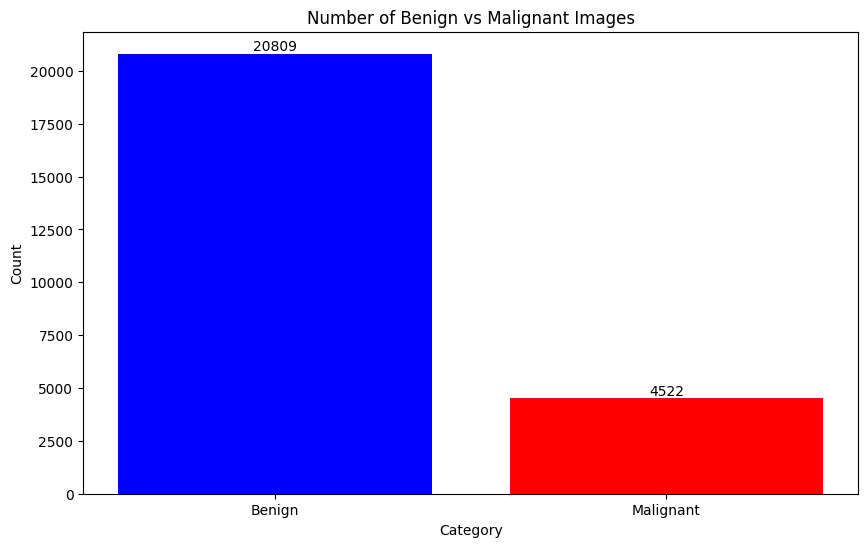

Number of Benign images: 20809
Number of Malignant images: 4522


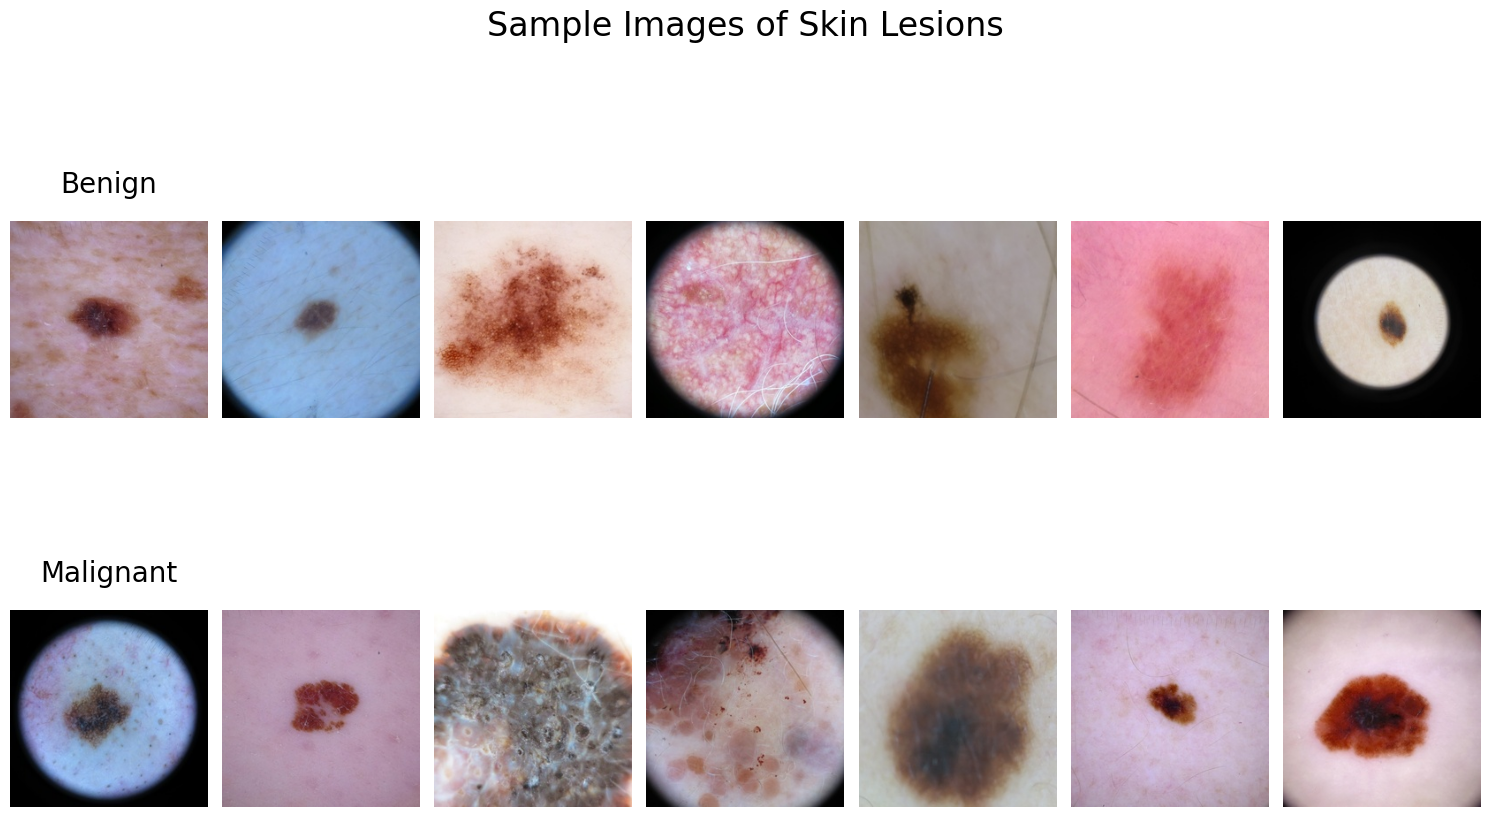

Total benign images: 20809
Total malignant images: 4522


In [5]:
# Image counts
benign_count = len(os.listdir('/content/output/benign'))
malignant_count = len(os.listdir('/content/output/malignant'))
counts = [benign_count, malignant_count]

plt.figure(figsize=(10, 6))
plt.bar(['Benign', 'Malignant'], counts, color=['blue', 'red'])
plt.title('Number of Benign vs Malignant Images')
plt.xlabel('Category')
plt.ylabel('Count')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

print(f"Number of Benign images: {benign_count}")
print(f"Number of Malignant images: {malignant_count}")


# Images of benign vs malignant images
CATEGORIES = ['benign', 'malignant']
SAMPLES_PER_CATEGORY = 7

fig, axes = plt.subplots(len(CATEGORIES), SAMPLES_PER_CATEGORY, figsize=(15, 10))
fig.suptitle('Sample Images of Skin Lesions', fontsize=24)

for i, category in enumerate(CATEGORIES):
    path = f'/content/output/{category}'
    images = os.listdir(path)

    for j in range(SAMPLES_PER_CATEGORY):
        img_name = np.random.choice(images)
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        axes[i, j].imshow(img_array)
        axes[i, j].axis('off')

        if j == 0:
            axes[i, j].set_title(f'{category.capitalize()}', fontsize=20, pad=20)

plt.tight_layout()
plt.show()

for category in CATEGORIES:
    path = f'/content/output/{category}'
    count = len(os.listdir(path))
    print(f"Total {category} images: {count}")

## **Data Processing, Normalization and Augmentation**




In [6]:
data_dir = '/content/output'
test_dir = '/content/test'

train_ds = tensorflow.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.33,
    subset="training",
    seed=123,
    image_size=(64, 64),
    batch_size=32,
    shuffle=True
)

val_ds = tensorflow.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.33,
    subset="validation",
    seed=123,
    image_size=(64, 64),
    batch_size=32,
    shuffle=True
)

test_ds = tensorflow.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(64, 64),
    batch_size=32,
)

data_augmentation = tensorflow.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

Found 25331 files belonging to 2 classes.
Using 16972 files for training.
Found 25331 files belonging to 2 classes.
Using 8359 files for validation.


## **Model Definition**

**1.** Here we have defined a Convolutional Neural Network Model for the classification of benign or malignant skin lesions with the Keras API. The Model consists of an Input layer which takes a 64x64 image shape with the RGB color channel. We have defined an alternating pattern of convolutional layer and max pooling layers. Allowing for feature extracting from the image and reducing spatial dimensions, assisting with computation speed. Following the alternating pattern, we have a Flatten layer which reshapes the previous output into a one-dimensional vector. We then havea layer of neurons using the Dense layer to  categorize the features obtained from previous layers. A Dropout is introduced to reduce overfitting.


**2.** The model is compiled use the adam loss optimizer, and the metric used is accuracy and loss function used is categorical crossentropy


**3.** Early stopping is included to reduce unneeded computation and prevent overfitting of the dataset.


**4.** Finally the model is trained on the dataset with 20 epochs.

In [ ]:
# 1.
model = tensorflow.keras.Sequential([
    data_augmentation,
    Rescaling(1./255),

    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPooling2D(2),

    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D(2),

    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D(2),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# 2.
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

# 3.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True )

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    mode="min",
    save_best_only=True,
)

# 4.
history = model.fit(
  train_ds,
  epochs=20,
  validation_data=val_ds,
  batch_size=32,
  verbose=1,
  callbacks=[early_stopping, checkpoint]
  )

## Testing the Model

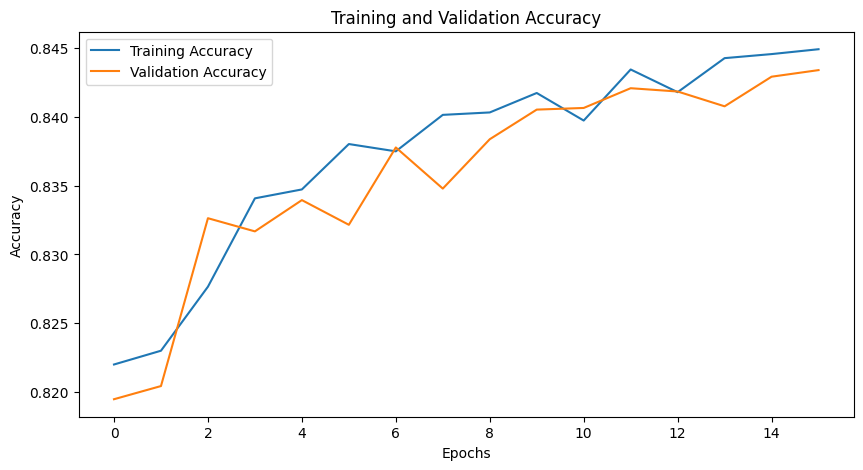

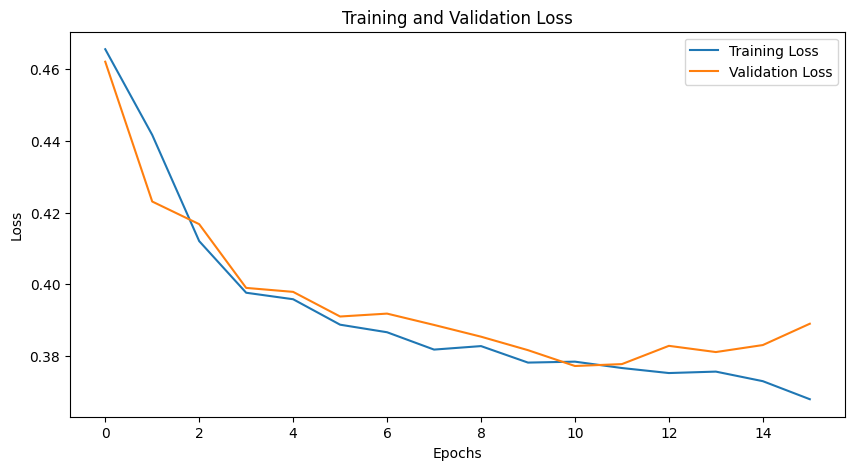

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 20

plt.figure(figsize=(10, 5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure(figsize=(10, 5))

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loss_test, acc_test = model.evaluate(test_ds, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

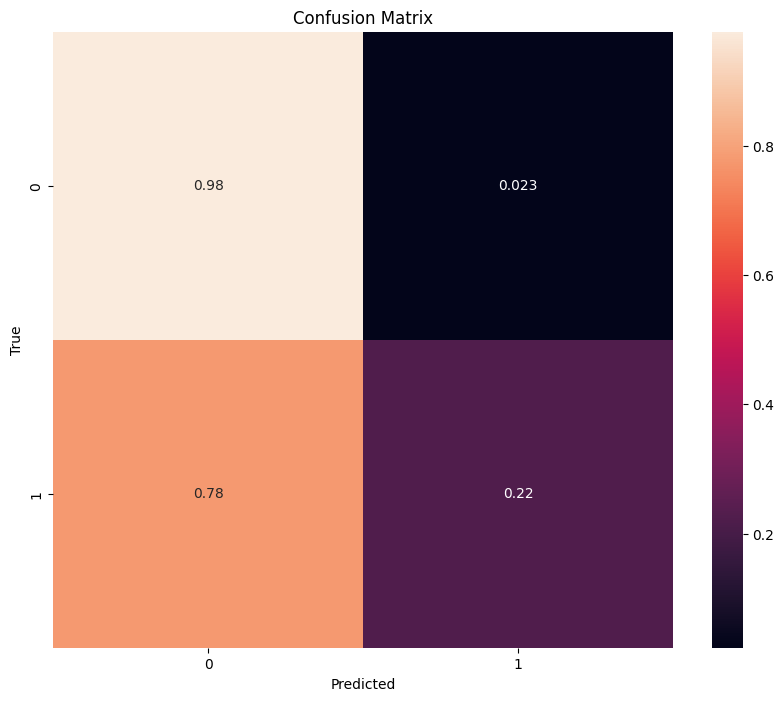

In [10]:
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images, verbose=0), axis=-1))

cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
model = load_model('best_model.keras')

def preprocess_image(image):
    image = cv2.resize(image, (64, 64))
    image = image / 255.0
    return image

def predict(image):
    if image is None:
        return "Please provide an image."

    processed_image = preprocess_image(image)
    input_image = np.expand_dims(processed_image, axis=0)
    prediction = model.predict(input_image)

    class_index = np.argmax(prediction)
    class_labels = ['Benign', 'Malignant']
    predicted_class = class_labels[class_index]
    confidence = prediction[0][class_index]

    return f"{predicted_class} (Confidence: {confidence:.2f})"

with gr.Blocks(title="Skin Lesion Classifier") as demo:
    gr.Markdown("# Skin Lesion Classifier")
    gr.Markdown("Upload an image of a skin lesion to classify it as benign or malignant.")

    with gr.Row():
        input_image = gr.Image(type="numpy", label="Input Image")
        output_text = gr.Textbox(label="Prediction")

    predict_button = gr.Button("Submit")
    predict_button.click(predict, inputs=input_image, outputs=output_text)

demo.launch()

